#  word2vec
1. 데이터 크롤링
2. 데이터셋 EDA, 전처리, Tokenization
3. word2vec 모델 생성
4. t-SNE를 이용한 시각화

In [ ]:
#Initial Setting (font, display)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

import matplotlib
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina'") #화질 보정

## 뉴스 데이터

빅카인즈 뉴스 데이터
검색어 : 인공지능

https://www.bigkinds.or.kr/v2/news/index.do

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/KUBIG 2-2 NLP/NewsResult_20220423-20220723.xlsx')

In [ ]:
df = data.loc[:, ['제목','본문']]
df.head()

,제목,본문
0,[세상사는 이야기] 멋진 신세계?,영국 작가 올더스 헉슬리가 '멋진 신세계(Brave New World)'를 쓴 건 ...
1,“미래교육 이렇게” 콘텐츠 한자리에,[KBS 울산]\n [앵커]\n\n 울산에서는 노후 학교를 미래형 학교로 바꾸는 사...
2,소아 희귀질환 AI로 잡는다 민관 연구개발 첫삽,【앵커】 \n\n우리 주변에는 희귀질환으로 고통받고 있는 어린이들이 적지 않은데요....
3,"트윔, 가전제품 제조사에 AI검사 솔루션 공급",[머니투데이 홍보경 기자] 인공지능 검사설비 전문기업인 ㈜트윔이 가전제품 제조사 C...
4,오늘의 날씨 - 오후 (2022년 07월 22일),"7월 22일 금요일, 오후 날씨입니다. \n \n이 시간 현재 일부 지방에 폭염주의..."


In [ ]:
df.shape

(5630, 2)

## 데이터 전처리
- 정규표현식 이용해서 한글만 남겨두기 (영어, 문자기호 제거)
- pykospacing 이용해서 한국어 띄어쓰기 교정
- hanspell 이용해서 한국어 맞춤법 교정

In [ ]:
#1) 정규표현식 (영어/숫자 기호/문자 제거)
import re

#텍스트 정제 함수: 한글 이외의 문자는 모두 제거
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') #한글과 띄어쓰기를 제외한 모든 글자 
    #hangul = re.compile('[^ \u3131-\u3163\uac00-\ud7a3]+') 위와 동일
    result = hangul.sub('', str(text))
    return(result)

In [ ]:
for i in range(len(df)):
  df.loc[i, 'kor'] = text_cleaning(df['본문'][i])
df.head(3)

,제목,본문,kor
0,[세상사는 이야기] 멋진 신세계?,영국 작가 올더스 헉슬리가 '멋진 신세계(Brave New World)'를 쓴 건 ...,영국 작가 올더스 헉슬리가 멋진 신세계 를 쓴 건 년이었다 셰익스피어의 희곡 템페...
1,“미래교육 이렇게” 콘텐츠 한자리에,[KBS 울산]\n [앵커]\n\n 울산에서는 노후 학교를 미래형 학교로 바꾸는 사...,울산 앵커 울산에서는 노후 학교를 미래형 학교로 바꾸는 사업이 진행 중인데요 이를...
2,소아 희귀질환 AI로 잡는다 민관 연구개발 첫삽,【앵커】 \n\n우리 주변에는 희귀질환으로 고통받고 있는 어린이들이 적지 않은데요....,앵커 우리 주변에는 희귀질환으로 고통받고 있는 어린이들이 적지 않은데요 민관이 손 ...


In [ ]:
#2) 띄어쓰기 교정 (PykoSpacing 패키지 사용)
!pip3 install git+https://github.com/haven-jeon/PyKoSpacing.git #한글 띄어쓰기(PyKoSpacing)

In [ ]:
from pykospacing import Spacing
spacing = Spacing()

In [ ]:
cleaned_corpus = []
for sent in df['kor']:
    cleaned_corpus.append(spacing(sent))

In [ ]:
spaced_corpus = cleaned_corpus
df['post_spaced'] = spaced_corpus
pd.set_option('display.max_colwidth', -1) #truncated되지 않고 post 모두 보여주기
df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,제목,본문,kor,post_spaced
0,[세상사는 이야기] 멋진 신세계?,영국 작가 올더스 헉슬리가 '멋진 신세계(Brave New World)'를 쓴 건 1931년이었다. 셰익스피어의 희곡 템페스트에서 제목을 따왔다. 제5막 1장 속 여주인공 미란다의 독백에서다. 제목은 가슴 벅차게 만드는데 정작 내용은 다르다. 인간의 암울한 미래를 심각하게 그린다.\n대전쟁에서 탄저균 같은 생화학무기가 사용돼 많은 인명이 살상된다. 종전 ..,영국 작가 올더스 헉슬리가 멋진 신세계 를 쓴 건 년이었다 셰익스피어의 희곡 템페스트에서 제목을 따왔다 제막 장 속 여주인공 미란다의 독백에서다 제목은 가슴 벅차게 만드는데 정작 내용은 다르다 인간의 암울한 미래를 심각하게 그린다대전쟁에서 탄저균 같은 생화학무기가 사용돼 많은 인명이 살상된다 종전,영국 작가 올더스 헉슬리가 멋진 신세계 를 쓴 건 년이었다 셰익스피어의 희곡 템페스트에서 제목을 따왔다 제막 장 속 여주인공 미란다의 독백에서 다 제목은 가슴 벅차게 만드는데 정작 내용은 다르다 인간의 암울한 미래를 심각하게 그린 다 대 전쟁에서 탄저균 같은 생화학무기가 사용돼 많은 인명이 살상된 다 종전
1,“미래교육 이렇게” 콘텐츠 한자리에,"[KBS 울산]\n [앵커]\n\n 울산에서는 노후 학교를 미래형 학교로 바꾸는 사업이 진행 중인데요,\n\n 이를 위한 콘텐츠들이 한자리에 모여 눈길을 끌었습니다.\n\n 박영하 기자가 현장을 다녀왔습니다.\n\n [리포트]\n\n 모니터의 앱을 실행하자 학교가 펼쳐집니다.\n\n 바닥을 비추자 다양하게 꾸며진 교실이 등장하고, 이곳저곳을 클릭하며 공부합니다.\n\n 온라인 도..",울산 앵커 울산에서는 노후 학교를 미래형 학교로 바꾸는 사업이 진행 중인데요 이를 위한 콘텐츠들이 한자리에 모여 눈길을 끌었습니다 박영하 기자가 현장을 다녀왔습니다 리포트 모니터의 앱을 실행하자 학교가 펼쳐집니다 바닥을 비추자 다양하게 꾸며진 교실이 등장하고 이곳저곳을 클릭하며 공부합니다 온라인 도,울산 앵커 울산에서는 노후 학교를 미래형 학교로 바꾸는 사업이 진행 중인데요 이를 위한 콘텐츠들이 한 자리에 모여 눈길을 끌었습니다 박영하 기자가 현장을 다녀왔습니다 리포트 모니터의 앱을 실행하자 학교가 펼쳐집니다 바닥을 비추자 다양하게 꾸며진 교실이 등장하고 이곳저곳을 클릭하며 공부합니다 온라인 도
2,소아 희귀질환 AI로 잡는다 민관 연구개발 첫삽,【앵커】 \n\n우리 주변에는 희귀질환으로 고통받고 있는 어린이들이 적지 않은데요. \n\n민관이 손 잡고 소아희귀질환 진단과 치료에 획기적인 전환점이 될 인공지능 개발에 나섰습니다. \n\n최한성 기자입니다. \n\n【기자】 \n\n에이퍼트 증후군. \n\n두개골 뼈들이 불완전하게 붙어 비정상적 머리가 만들어지는 희귀질환입니다. \n\n아이가 이 병 진단을 받았을 때 엄마의 ..,앵커 우리 주변에는 희귀질환으로 고통받고 있는 어린이들이 적지 않은데요 민관이 손 잡고 소아희귀질환 진단과 치료에 획기적인 전환점이 될 인공지능 개발에 나섰습니다 최한성 기자입니다 기자 에이퍼트 증후군 두개골 뼈들이 불완전하게 붙어 비정상적 머리가 만들어지는 희귀질환입니다 아이가 이 병 진단을 받았을 때 엄마의,앵커 우리 주변에는 희귀질환으로 고통 받고 있는 어린이들이 적지 않은데요 민관이 손 잡고 소아 희귀질환 진단과 치료에 획기적인 전환점이 될 인공지능 개발에 나섰습니다 최한성 기자입니다 기자 에이퍼트 증후군 두개골 뼈들이 불완전하게 붙어 비정상적 머리가 만들어지는 희귀질환입니다 아이가 이 병 진단을 받았을 때 엄마의


In [ ]:
del df['본문']
del df['kor']

In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git

In [ ]:
#3) 맞춤법 교정 (hanspell 패키지 사용)
from hanspell import spell_checker

corpus = []
for sent in spaced_corpus:
    try:
      spelled_sent = spell_checker.check(sent)
      checked_sent = spelled_sent.checked
      corpus.append(checked_sent)
    except:
      pass

everytime_data['spelled'] = corpus
everytime_data.head(3)

## Gensim 패키지로 word2vec 모델 훈련
- `Word2Vec()`<br>
In this first step, I set up the parameters of the model one-by-one.
I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.

- `build_vocab()`<br>
Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
With the loggings, I can follow the progress and even more important, the effect of min_count and sample on the word corpus. I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.

- `train()`<br>
Finally, trains the model.
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.



 **Word2Vec의 파라미터 리스트**
- `min_count` = int<br>Ignores all words with total absolute frequency lower than this - (2, 100)
- `window` = int<br>The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
- `size` = int<br>Dimensionality of the feature vectors. - (50, 300)
- `sample` = float<br>The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
- `alpha` = float<br>The initial learning rate - (0.01, 0.05)
- `min_alpha` = float<br>Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
- `negative` = int<br>If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
- `workers` = int<br>Use these many worker threads to train the model (=faster training with multicore machines)



size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.

window = 컨텍스트 윈도우 크기

min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)

workers = 학습을 위한 프로세스 수

sg = 0은 CBOW, 1은 Skip-gram.

In [ ]:
#빈도높은 bigram까지 함께 고려
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df['post_spaced']]
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [ ]:
bigram = Phraser(phrases)
sentences = bigram[sent]

### 1) CBOW : window = 2

In [ ]:
#Word2vec 모델 생성 .Word2Vec()
import multiprocessing
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=5,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     sg = 0)

In [ ]:
from time import time

In [ ]:
#Word2vec 사전 생성 .build_vocab()
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.04 mins


In [ ]:
#Word2vec 모델 훈련 .train()
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.17 mins


In [ ]:
w2v_model.init_sims(replace=True)

In [ ]:
#'인공지능'과 가장 유사한 단어 찾기
w2v_model.wv.most_similar(positive=["인공지능"])

[('초거대', 0.9081190824508667),
 ('빅데이터', 0.9029040336608887),
 ('개발한', 0.8904932737350464),
 ('서비스형', 0.8904358148574829),
 ('접목한', 0.8869642019271851),
 ('인공지능_기반', 0.8861119747161865),
 ('암', 0.8859533071517944),
 ('분석', 0.8856795430183411),
 ('기반의', 0.8850234746932983),
 ('멀티모달', 0.8849297761917114)]

In [ ]:
#2개의 단어 사이 유사도 측정하기
w2v_model.wv.similarity('인공지능', '네이버')

0.5967969

In [ ]:
#2개의 단어 사이 유사도 측정하기
w2v_model.wv.similarity('인공지능', '카카오')

0.756055

In [ ]:
#2개의 단어 사이 유사도 측정하기
w2v_model.wv.similarity('인공지능', '삼성')

0.40760955

In [ ]:
#3개 단어 중 안 어울리는 단어 찾기
w2v_model.wv.doesnt_match(['인공지능', '딥러닝', '연구'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'연구'

### 2) CBOW : window = 4

In [ ]:
#Word2vec 모델 생성 .Word2Vec()
import multiprocessing
from gensim.models import Word2Vec

w2v_model2 = Word2Vec(min_count=50,
                     window=4,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     sg = 0)

In [ ]:
#Word2vec 사전 생성 .build_vocab()
t = time()
w2v_model2.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.02 mins


In [ ]:
#Word2vec 모델 훈련 .train()
t = time()
w2v_model2.train(sentences, total_examples=w2v_model2.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.66 mins


In [ ]:
w2v_model2.init_sims(replace=True)

In [ ]:
#'인턴'과 가장 유사한 단어 찾기
w2v_model2.wv.most_similar(positive=["인공지능"])

[('기반', 0.9967983365058899),
 ('분석', 0.9965205192565918),
 ('빅데이터', 0.9948844909667969),
 ('통합', 0.9948004484176636),
 ('플랫폼', 0.9945631623268127),
 ('지원하는', 0.9945155382156372),
 ('전문기업', 0.9944188594818115),
 ('사업이_다', 0.9941688776016235),
 ('서비스', 0.9940670728683472),
 ('선정돼', 0.993440568447113)]

### 3) Skip-gram : window= 2

In [ ]:
#Word2vec 모델 생성 .Word2Vec()
import multiprocessing
from gensim.models import Word2Vec

skip_model = Word2Vec(min_count=50,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     sg = 1)

In [ ]:
#Word2vec 사전 생성 .build_vocab()
t = time()
skip_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.02 mins


In [ ]:
#Word2vec 모델 훈련 .train() #######
t = time()
skip_model.train(sentences, total_examples=skip_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.48 mins


In [ ]:
skip_model.init_sims(replace=True)

In [ ]:
#'인공지능'과 가장 유사한 단어 찾기
skip_model.wv.most_similar(positive=["인공지능"])

[('관한', 0.9714348316192627),
 ('활용해', 0.9624631404876709),
 ('나선_다', 0.9623318314552307),
 ('헤럴드경제_구본혁', 0.9614811539649963),
 ('공동', 0.9605449438095093),
 ('처리', 0.9601809978485107),
 ('학습', 0.9596188068389893),
 ('따라', 0.9587211608886719),
 ('활용한', 0.9584600329399109),
 ('컴퓨팅', 0.9581539630889893)]

### 4) Skip-gram : window = 4

In [ ]:
#Word2vec 모델 생성 .Word2Vec()
import multiprocessing
from gensim.models import Word2Vec

skip_model2 = Word2Vec(min_count=50,
                     window=4,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     sg = 1)

In [ ]:
#Word2vec 사전 생성 .build_vocab()
t = time()
skip_model2.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.03 mins


In [ ]:
#Word2vec 모델 훈련 .train()
t = time()
skip_model2.train(sentences, total_examples=skip_model2.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.85 mins


In [ ]:
skip_model2.init_sims(replace=True)

In [ ]:
#'인공지능'과 가장 유사한 단어 찾기
skip_model2.wv.most_similar(positive=["인공지능"])

[('관한', 0.9618526697158813),
 ('활동을', 0.9254751205444336),
 ('헤럴드경제_구본혁', 0.9207878708839417),
 ('지난해_월', 0.9179337024688721),
 ('공동', 0.9169391989707947),
 ('인공지능을_활용한', 0.9141960740089417),
 ('일까지', 0.9141745567321777),
 ('개발을', 0.9134916067123413),
 ('따라', 0.9129443168640137),
 ('은', 0.9122023582458496)]

## t-SNE를 이용한 시각화

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    #query 단어의 벡터 표현 (빨강)
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    #query 단어와 가장 유사한 단어들 찾기
    close_words = model.wv.most_similar([word])
    
    #위에서 찾은 유사한 단어들의 벡터 표현 (파랑)
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    #각 입력된 list내 단어 벡터 표현 (초록)
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    #PCA로 300에서 50으로 차원 감소
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    #t-SNE 좌표를 2차원에서 찾아줌
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    #각 벡터 포인트에 annotation 추가
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

### 1) CBOW : window = 2

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


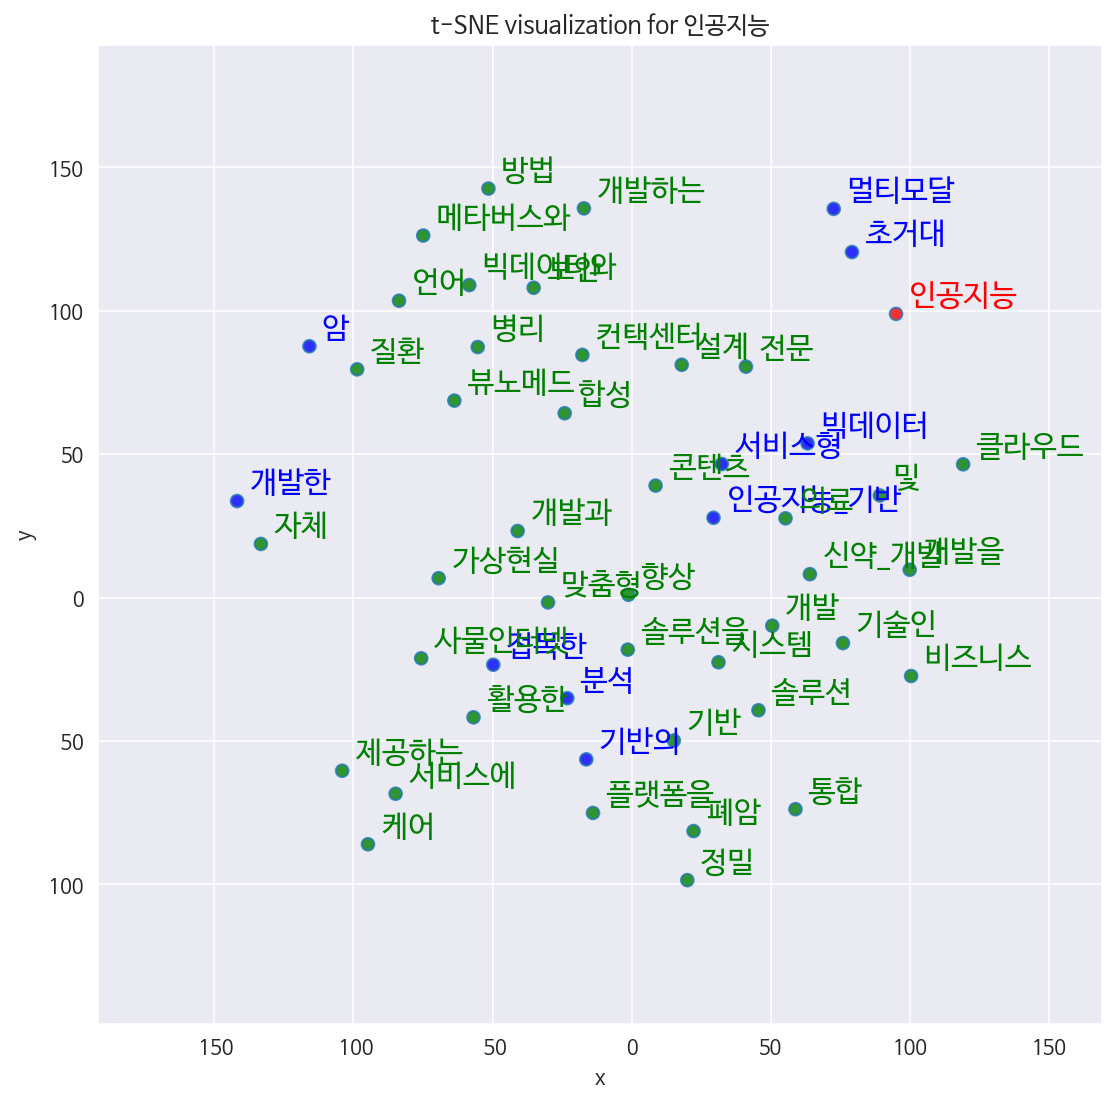

In [ ]:
tsnescatterplot(w2v_model, "인공지능", [t[0] for t in w2v_model.wv.most_similar(positive=["인공지능"], topn=50)][10:])

### 2) CBOW : window =4

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


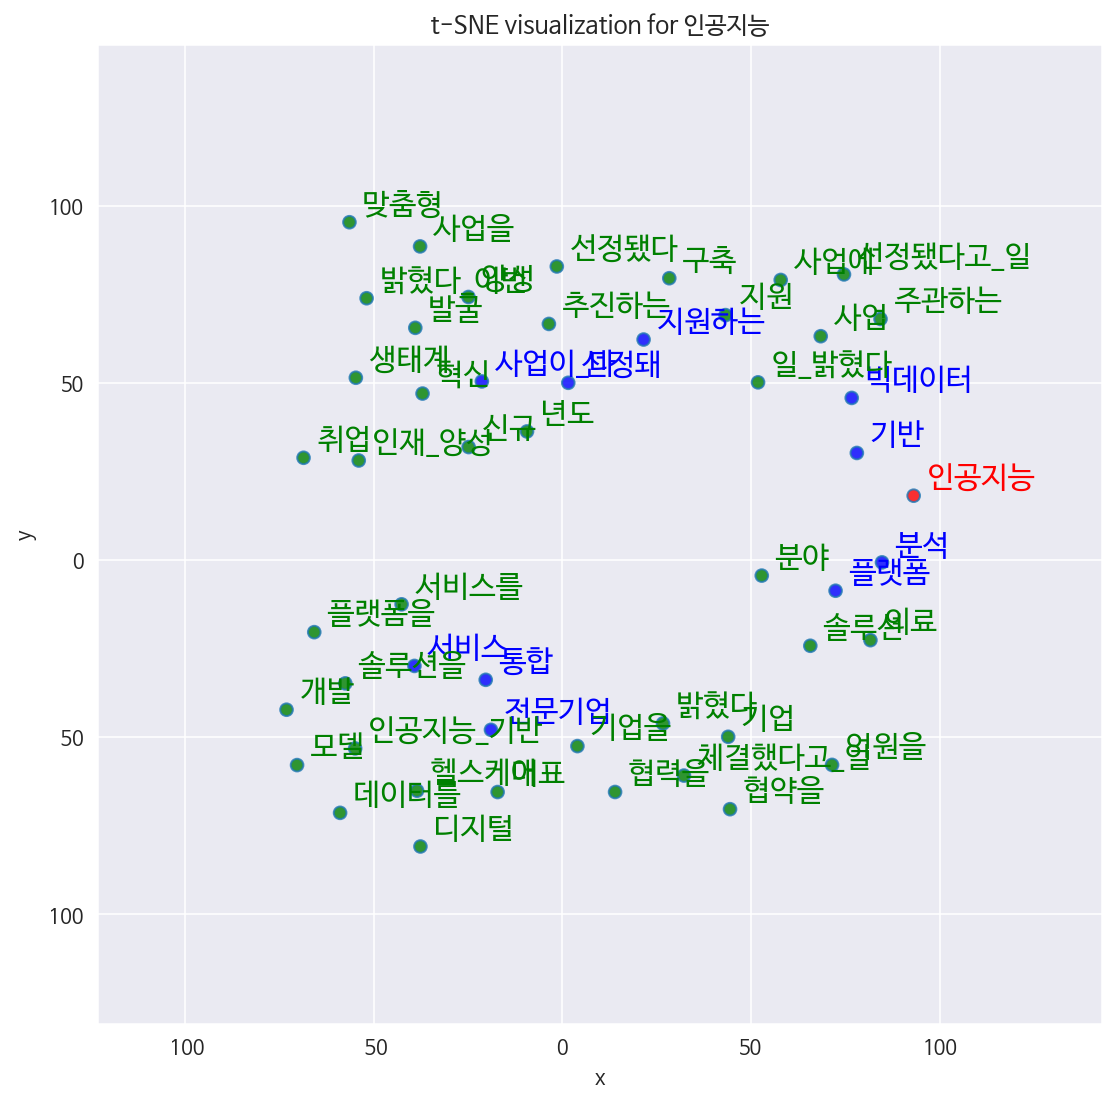

In [ ]:
tsnescatterplot(w2v_model2, "인공지능", [t[0] for t in w2v_model2.wv.most_similar(positive=["인공지능"], topn=50)][10:])

 ### 3) Skip-gram : window = 2

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


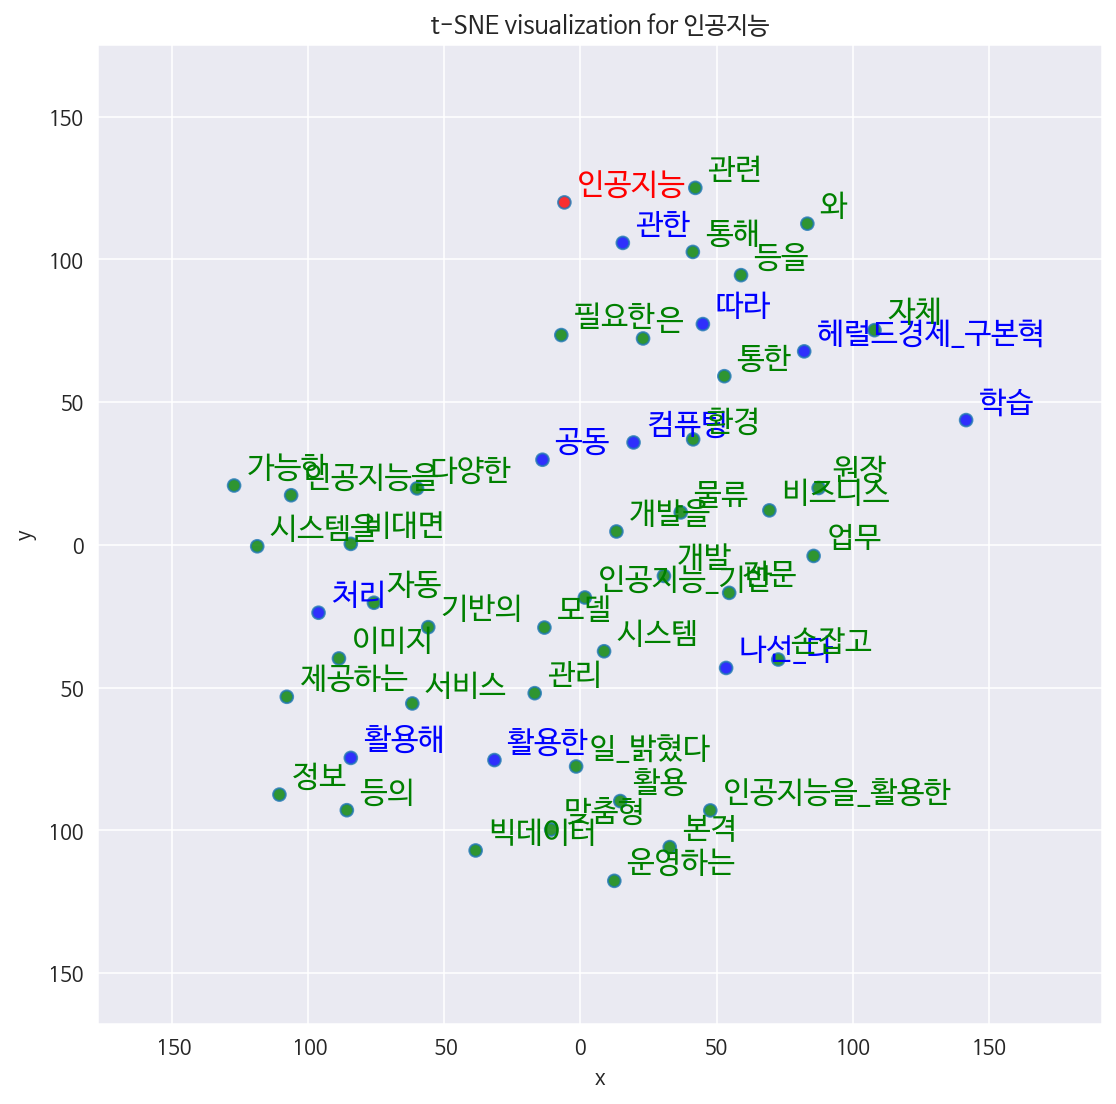

In [ ]:
tsnescatterplot(skip_model, "인공지능", [t[0] for t in skip_model.wv.most_similar(positive=["인공지능"], topn=50)][10:])

### 4) Skip-gram : window = 4

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


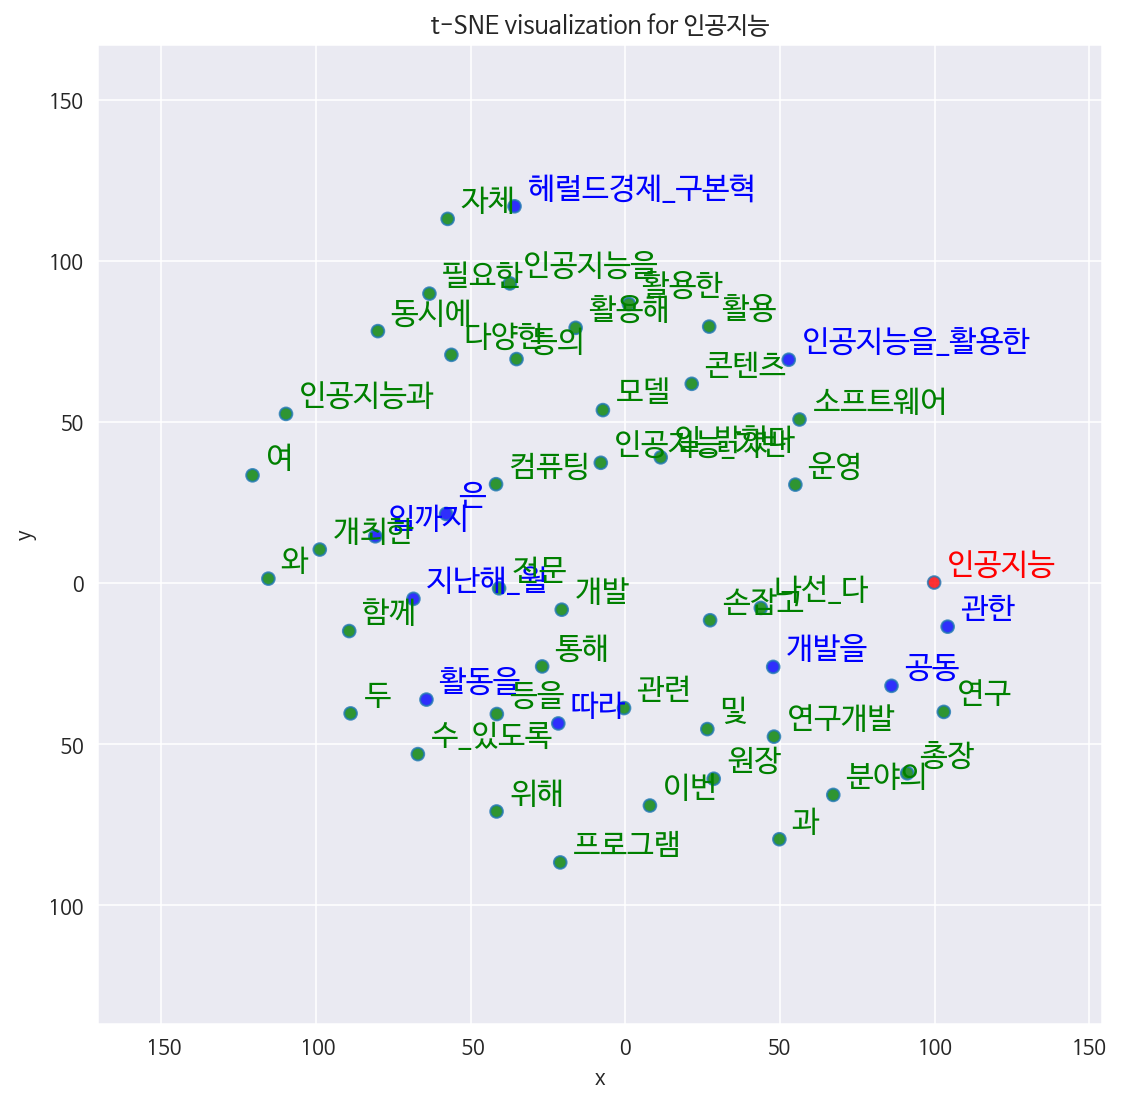

In [ ]:
tsnescatterplot(skip_model2, "인공지능", [t[0] for t in skip_model2.wv.most_similar(positive=["인공지능"], topn=50)][10:])